In [20]:
import os
import sys
from sys import platform
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

# Add the parent directory to the sys.path (without this we cannot import constants or scripts)
sys.path.insert(0, str(Path.cwd().parent))
from src.plotting import plot_comparison_GER_HIC_GLO
from constants.countries import highincome_countries
from src.utils import get_iso3_gbd, generate_high_income_global_avg_index

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import matplotlib.pyplot as plt 

from tueplots import bundles

In [22]:
# if platform == 'darwin': # macos
#     print('mac os')
#     os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [23]:
DATA_PATH = '../data/final'
OUTPUT_PATH = '../doc/IHD_germany_2024/fig'
cvd_data_path = f'{DATA_PATH}/gbd_ischemicHeartDisease_DeathsIncidence.csv'
YEAR_COLUMN_NAME = 'year'
VALUE_COLUMN_NAME = 'val'

## Load Data

In [26]:
df = pd.read_csv(cvd_data_path)
df = df[df.measure_name=='Deaths']
df['country_code'] = df['location_name'].map(get_iso3_gbd)
df

,measure_name,location_name,cause_name,year,Value,upper,lower,country_code
0,Deaths,Greece,Ischemic heart disease,1990,198.963673,206.809839,187.732342,GRC
1,Deaths,Lesotho,Ischemic heart disease,1990,38.577482,47.023134,29.860005,LSO
2,Deaths,Djibouti,Ischemic heart disease,1990,19.784015,25.606502,15.357142,DJI
3,Deaths,Global,Ischemic heart disease,1990,106.468267,110.197494,101.034486,GLB
4,Deaths,Chile,Ischemic heart disease,1990,82.872330,85.753086,78.615036,CHL
...,...,...,...,...,...,...,...,...
6175,Deaths,Egypt,Ischemic heart disease,2019,183.592812,235.826570,140.263637,EGY
6176,Deaths,Sweden,Ischemic heart disease,2019,185.615296,206.258708,162.007861,SWE
6177,Deaths,Palau,Ischemic heart disease,2019,226.686367,283.109676,181.515902,PLW
6178,Deaths,Yemen,Ischemic heart disease,2019,102.545335,133.696347,82.594918,YEM


In [27]:
df = df[['location_name', 'country_code', 'year', 'Value']]
df.columns = ['Country Name', 'Country Code', 'Year', 'IHD']

In [28]:
df['Country Code'].nunique()

206

In [29]:
health_df = pd.read_csv('../data/raw/oecd_healthSpending.csv')
health_df.rename(columns={'LOCATION': 'Country Code', 'TIME': 'Year', 'Value': 'HealthInd'}, inplace=True)
health_df.drop(columns=['INDICATOR', 'SUBJECT', 'MEASURE', 'FREQUENCY', 'Flag Codes'], inplace=True)
health_df

,Country Code,Year,HealthInd
0,AUS,1971,212.545
1,AUS,1972,226.524
2,AUS,1973,251.085
3,AUS,1974,306.927
4,AUS,1975,374.393
...,...,...,...
1732,PER,2016,622.679
1733,PER,2017,623.425
1734,PER,2018,686.332
1735,PER,2019,702.355


In [30]:
# health_df = pd.read_csv(DATA_PATH+'/oecd_combined_final.csv')
# health_df = health_df.rename({'Value': 'HealthInd'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [31]:
fat_df = pd.read_csv(DATA_PATH+'/daily_per_capita_fat_supply_final.csv')
fat_df = fat_df.rename({'Value': 'Fat'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [32]:
alc_df = pd.read_csv('../data/raw/alcohol_germany.csv')
alc_df = alc_df[['LOCATION', 'TIME', 'Value']]
alc_df.columns = ['Country Code', 'Year', 'Alcohol']
# alc_df = alc_df.rename({'Value': 'Alcohol'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [33]:
alc_df['Country Code'].nunique()

49

In [34]:
age_df = pd.read_csv('../data/raw/median-age.csv')
age_df = age_df[['Code', 'Year', 'Median age - Sex: all - Age: all - Variant: estimates']]
age_df.columns = ['Country Code', 'Year', 'Age']

In [35]:
final_df = df.merge(health_df, on=['Country Code', 'Year'])
final_df = final_df.merge(alc_df, on=['Country Code', 'Year'])
# final_df = final_df.merge(fat_df, on=['Country Code', 'Year'])
final_df = final_df.merge(age_df, on=['Country Code', 'Year'])

In [36]:
final_df['Country Name'].nunique()

48

In [37]:
mean_df = final_df.groupby(['Country Name', 'Country Code'])[['IHD', 'HealthInd', 'Alcohol', 'Age']].last().reset_index()

In [38]:
%autoreload 2
# mean_df = generate_high_income_global_avg_index(mean_df, value_cols=['IHD', 'HealthInd', 'Alcohol', 'Age'], year_col=None)

In [39]:
from src.plotting import bubble_plot_factors_and_rates

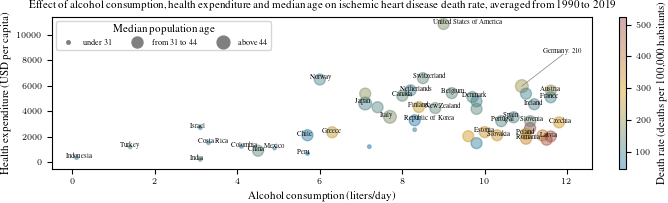

In [42]:
%autoreload 2

output_fig_path = OUTPUT_PATH + '/fig_bubble_plot_factors.pdf'
bubble_plot_factors_and_rates(mean_df, x_col='Alcohol', y_col='HealthInd', size_col='Age', hue_col='IHD',
                            x_label='Alcohol consumption (liters/day)', y_label='Health expenditure (USD per capita)',
                            size_label='Median population age', hue_label='Death rate (deaths per 100,000 habitants)',
                            country_col='Country Name',
                            title='Effect of alcohol consumption, health expenditure and median age on ischemic heart disease death rate, averaged from 1990 to 2019',
                            output_path=output_fig_path)